In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import GPy

from pyFDA import bspline

In [3]:
%matplotlib inline

In [4]:
def poolAdjacentViolators(y):
    z = np.array(y.tolist())
    
    return poolAdjacentViolators_recursive(z,1)

def poolAdjacentViolators_recursive(y,depth=1):
    if depth == y.shape[0]:
        return y
    
    for i in range(y.shape[0]-depth):
        if y[i+depth] < y[i]:
            y[i:i+depth+1] = np.mean(y[i:i+depth+1])
            
    if np.any(y[1:] < y[:-1]):
        return poolAdjacentViolators_recursive(y,depth+1)
    return y

In [20]:
def sampleGP(gp,t,size=1,monotone=False):
    mu,cov = gp.predict(t,full_cov=True)
    sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov,size=size)
    if monotone:
        if size == 1:
            return poolAdjacentViolators(sample)
        for i in range(size):
            sample[i,:] = poolAdjacentViolators(sample[i,:])
        return sample
    else:
        return sample

# Prior for the registration function 

In [6]:
def registrationPrior(t0,t1,ratio):

    t = np.array([t0,t1])[:,None]
    mapping = GPy.mappings.Linear(1,1)
    mapping.A = 1
    mapping.A.fix()
    gp = GPy.models.GPRegression(t,t,mean_function=mapping)
    gp.Gaussian_noise=1e-6
    gp.kern.lengthscale= 1.*(t1-t0) * ratio
    return gp

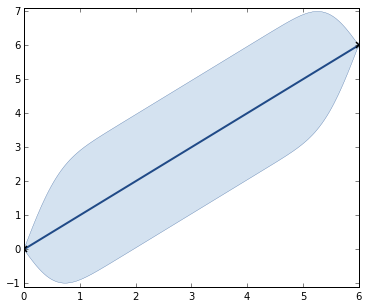

In [540]:
regPrior = registrationPrior(0,6,.1)

fig = plt.figure(figsize=(6,5))
regPrior.plot(fignum=fig.number)
plt.xlim(0,6)
plt.ylim(-1.1,7.1)

plt.savefig("figures/regPrior_likelihood.png")

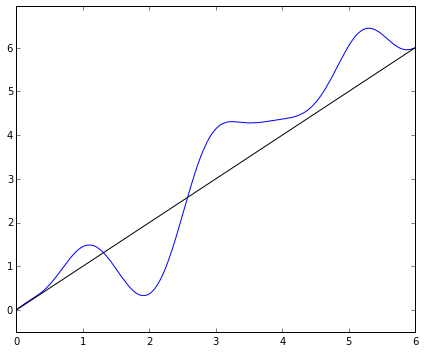

In [541]:
t = np.linspace(0,6,200)
mu,cov = regPrior.predict(t[:,None],full_cov=True)
sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov)

plt.figure(figsize=(6,5))

# plt.subplot(121)
plt.plot(t,sample)
plt.plot(t,t,'k')
plt.ylim(np.min(sample)-.5,np.max(sample)+.5)

# plt.subplot(122)
# plt.imshow(cov,origin=0)

plt.tight_layout()

plt.savefig("figures/regPrior_sample.png")

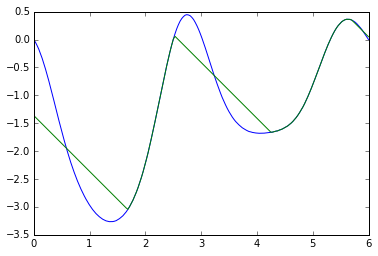

In [9]:
plt.plot(t,sample-t)
plt.plot(t,poolAdjacentViolators(sample)-t)

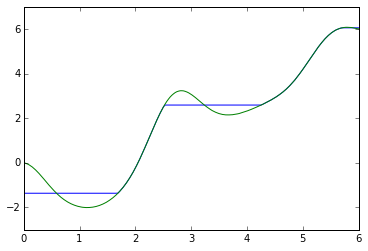

In [10]:
plt.plot(t,poolAdjacentViolators(sample))
plt.plot(t,sample)

# Prior for the mean function

In [11]:
def meanPrior(t0,t1,sigma=.1,lengthscale=1):

    t = np.array([t0,t1])[:,None]
    y = np.array([0,0])[:,None]
    mapping = GPy.mappings.Linear(1,1)
    mapping.A = 0
    mapping.A.fix()
    gp = GPy.models.GPRegression(t,y,mean_function=mapping)
    gp.Gaussian_noise=sigma
    gp.kern.lengthscale= lengthscale
    return gp

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f6788b798d0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f6788b6c050>],
  [<matplotlib.lines.Line2D at 0x7f6788b6cdd0>]]}

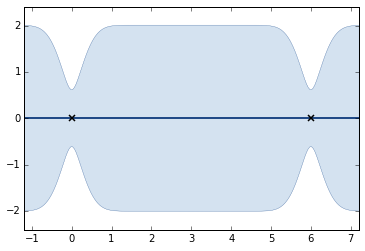

In [12]:
mPrior = meanPrior(0,6,.05,.5)
mPrior.plot()

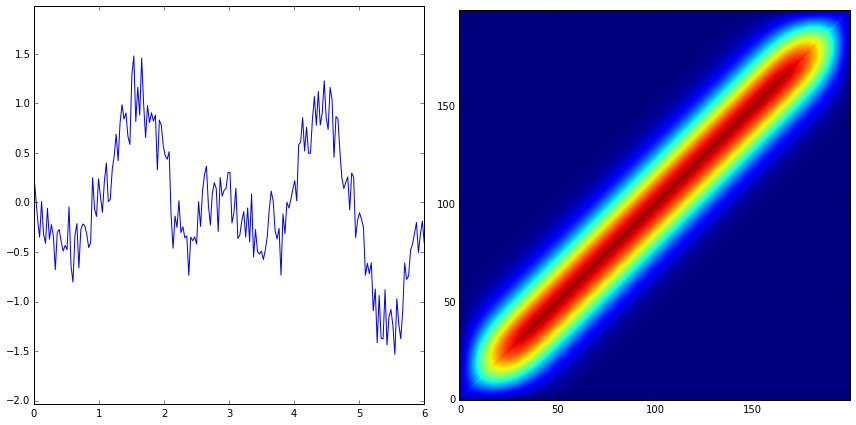

In [13]:
mu,cov = mPrior.predict(t[:,None],full_cov=True)
sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(t,sample)
plt.ylim(np.min(sample)-.5,np.max(sample)+.5)

plt.subplot(122)
plt.imshow(cov,origin=0)

plt.tight_layout()

# Example data

In [14]:
def gFunction(t,theta):
	return np.exp(theta[0]) *(t+theta[1])

In [192]:
n = 50
t = np.linspace(0,6,n)
k = 5

regPrior = registrationPrior(0,6,.15)
h = sampleGP(regPrior,t[:,None])
hspline = bspline.Bspline(t,h)

x = np.cos(t**3/(np.pi**2))

y = np.cos(hspline(t)**3/(np.pi**2)) + scipy.stats.norm.rvs(scale=.05,size=n)
x += scipy.stats.norm.rvs(scale=.05,size=n)

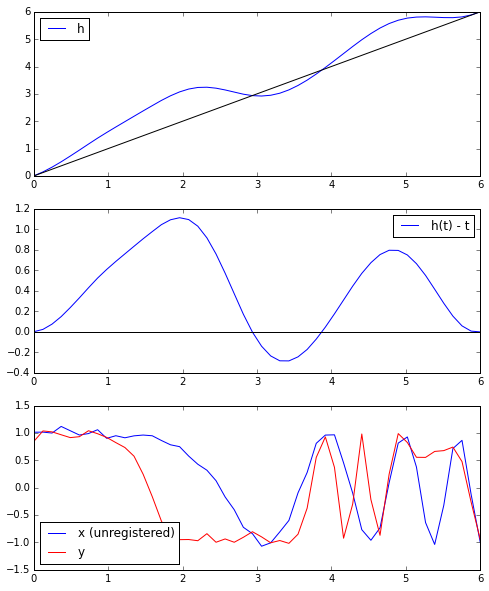

In [193]:
plt.figure(figsize=(8,10))

plt.subplot(313)
plt.plot(t,x,label="x (unregistered)")
plt.plot(t,y,'r',label="y")
plt.legend(loc="best")

plt.subplot(311)
plt.plot(t,h,label="h")
plt.plot([0,6],[0,6],'k')
plt.legend(loc="best")

plt.subplot(312)
plt.plot(t,h-t,label="h(t) - t")
plt.plot([0,6],[0,0],'k')
plt.legend(loc="best")

plt.savefig("figures/bayesianModel_dataGeneration.png",bbox_inches="tight",dpi=300)

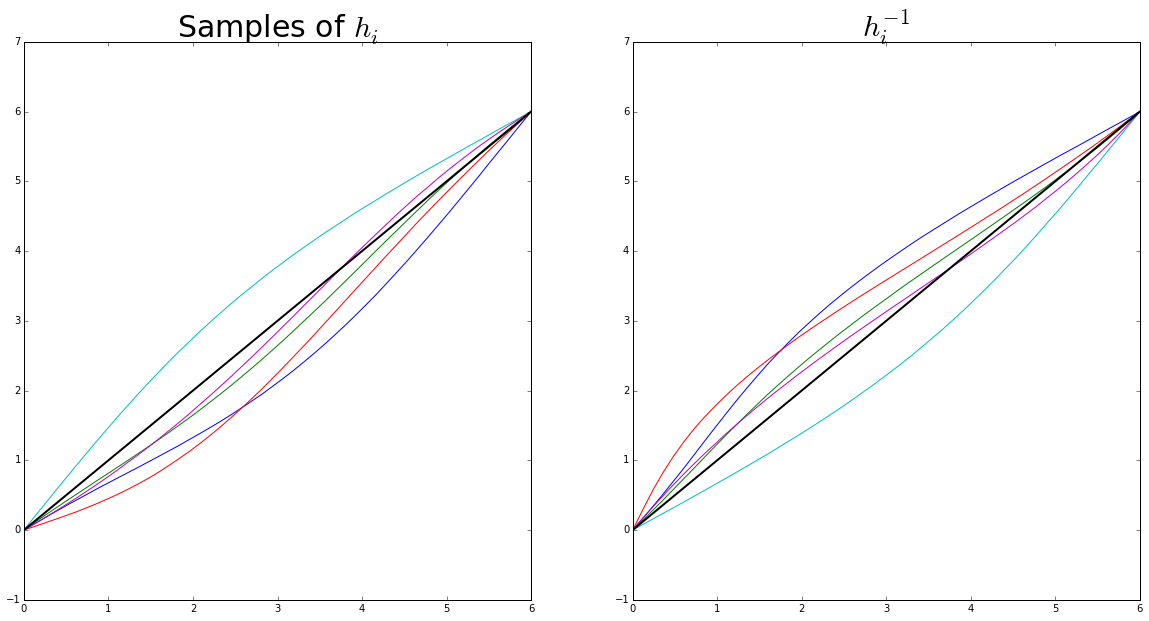

In [194]:
regPrior = registrationPrior(0,6,.5)
hsamples = sampleGP(regPrior,t[:,None],k,monotone=True)
hsamplesInvert = np.array([bspline.Bspline(hs,t)(t) for hs in hsamples.tolist()])

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(t,hsamples.T);
plt.plot([0,6],[0,6],'k',linewidth=2)
plt.title("Samples of $h_i$",fontsize=30)


plt.subplot(122)
plt.plot(t,hsamplesInvert.T);
plt.plot([0,6],[0,6],'k',linewidth=2)
plt.title("$h_i^{-1}$",fontsize=30)

plt.savefig("figures/bayesianModel_registrationSamples.png",bbox_inches="tight",dpi=300)

In [195]:
yGP = GPy.models.GPRegression(t[:,None],x[:,None]+ scipy.stats.norm.rvs(scale=.2,size=n)[:,None])
yGP.optimize()
yGP

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.680289800428,+ve,,
rbf.lengthscale,0.244831134556,+ve,,
Gaussian_noise.variance,0.0395143375292,+ve,,


In [196]:
xRegSample = np.array([sampleGP(yGP,hi[:,None]) for hi in hsamplesInvert])
xRegSample.shape

(5, 50)

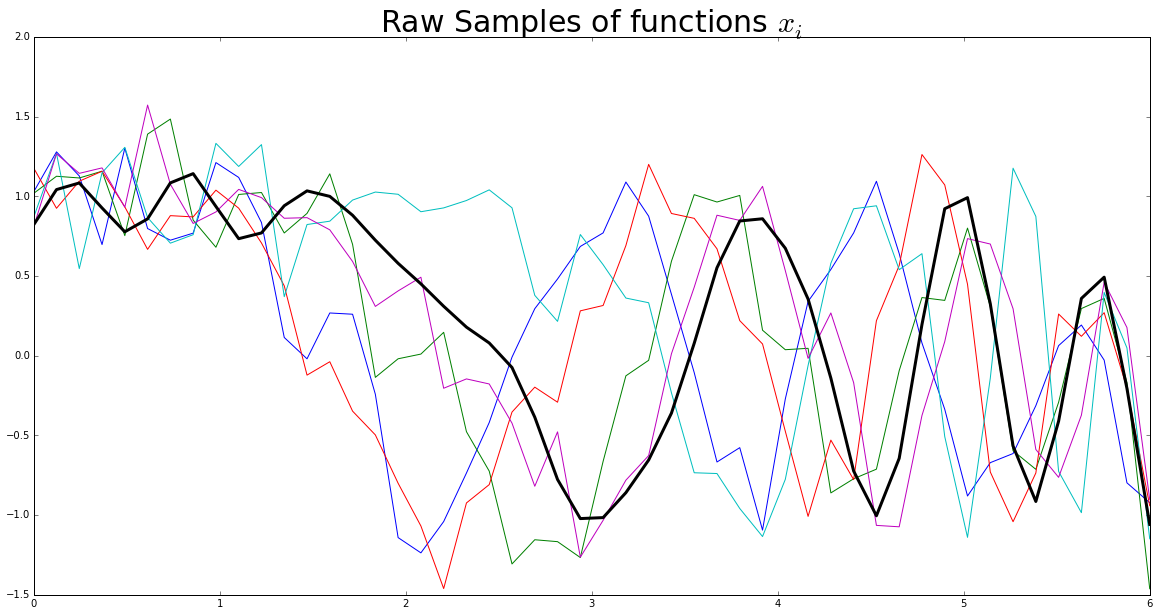

In [197]:
plt.figure(figsize=(20,10))
    
plt.plot(t,xRegSample.T)
    
mu,var = yGP.predict(t[:,None])
plt.plot(t,mu[:,0],'k',linewidth=3)

plt.title("Raw Samples of functions $x_i$",fontsize=30)
plt.savefig("figures/bayesianModel_rawSamples.png",bbox_inches="tight",dpi=300)

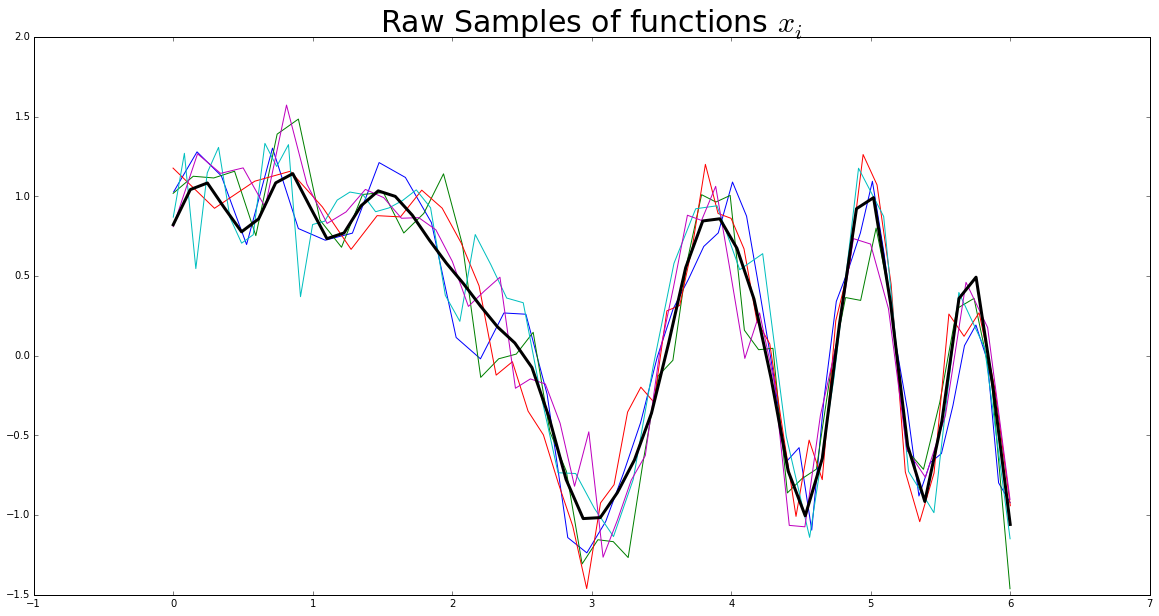

In [229]:
plt.figure(figsize=(20,10))
    
plt.plot(hsamplesInvert.T,xRegSample.T)
    
mu,var = yGP.predict(t[:,None])
plt.plot(t,mu[:,0],'k',linewidth=3)

plt.title("Raw Samples of functions $x_i$",fontsize=30)
plt.savefig("figures/bayesianModel_registeredSamples.png",bbox_inches="tight",dpi=300)

In [198]:
xGPs = [GPy.models.GPRegression(t[:,None],np.array(xreg)[:,None]) for xreg in xRegSample.tolist()]
[xgp.optimize() for xgp in xGPs]

[None, None, None, None, None]

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f67778a6610>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f67778d3d50>],
  [<matplotlib.lines.Line2D at 0x7f677789db10>]]}

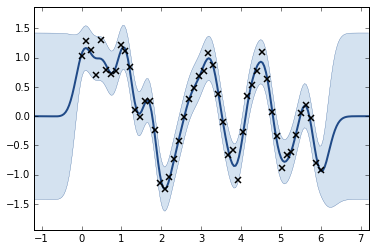

In [207]:
xGPs[0].plot()

In [231]:
tpred = np.linspace(0,6,200)

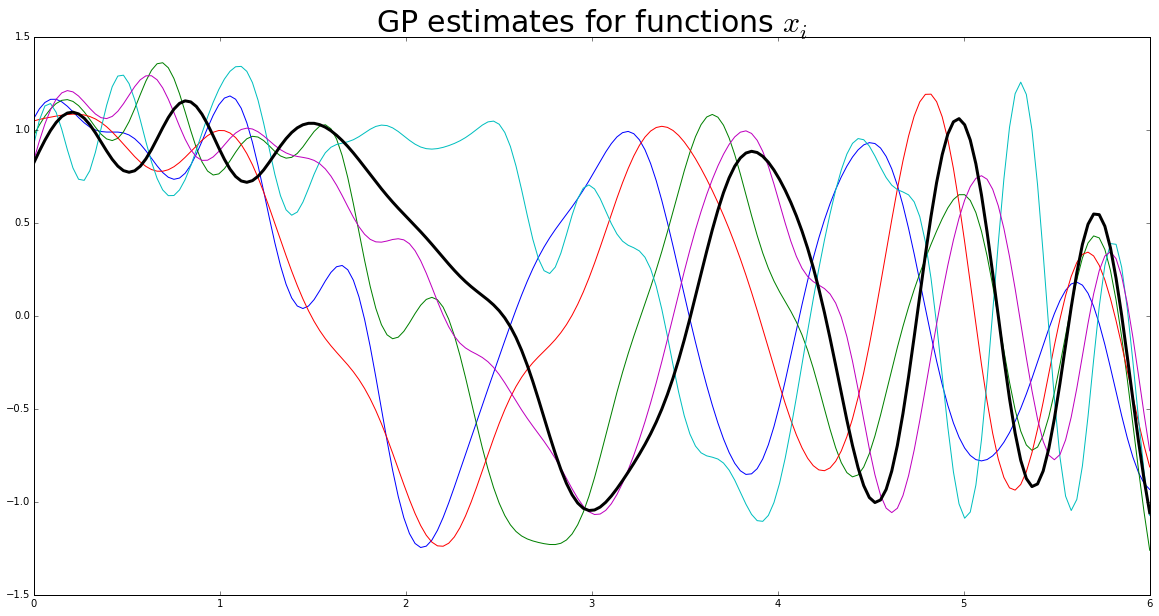

In [233]:
plt.figure(figsize=(20,10))

for i,xgp in enumerate(xGPs):
    mu,var = xgp.predict(tpred[:,None])
    plt.plot(tpred,mu)
    
mu,var = yGP.predict(tpred[:,None])
plt.plot(tpred,mu[:,0],'k',linewidth=3)

plt.title("GP estimates for functions $x_i$",fontsize=30)
plt.savefig("figures/bayesianModel_gpEstimates.png",bbox_inches="tight",dpi=300)

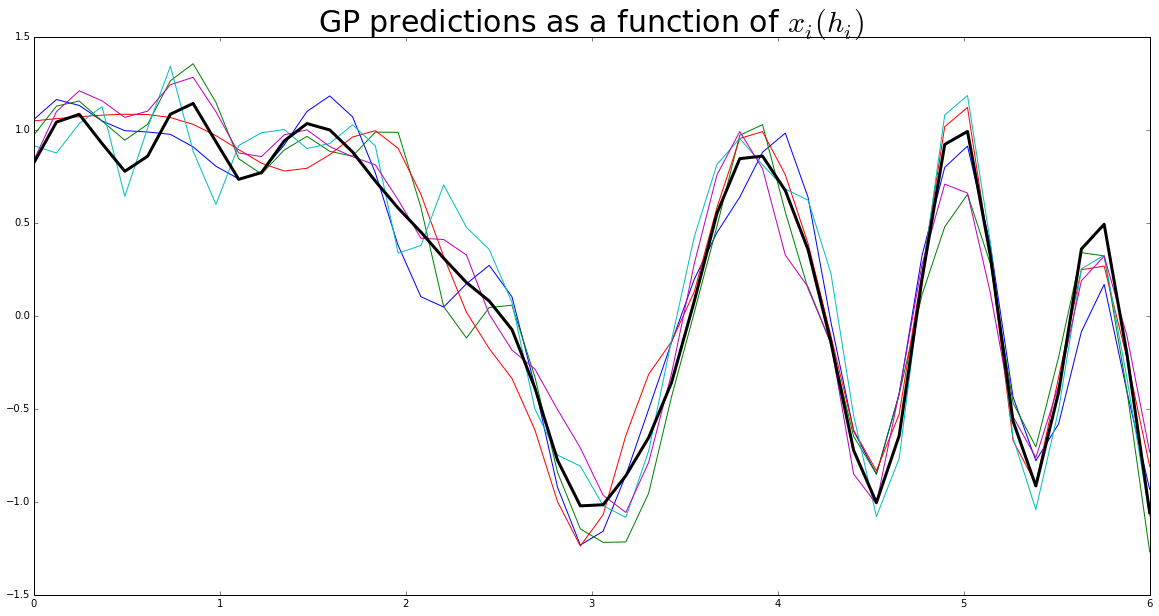

In [200]:
plt.figure(figsize=(20,10))

for i,xgp in enumerate(xGPs):
    mu,var = xgp.predict(hsamples[i,:][:,None])
    plt.plot(t,mu)
    
mu,var = yGP.predict(t[:,None])
plt.plot(t,mu[:,0],'k',linewidth=3)

plt.title("GP predictions as a function of $x_i(h_i)$",fontsize=30)
plt.savefig("figures/bayesianModel_gpRegister.png",bbox_inches="tight",dpi=300)

In [437]:
def proposalSample(t,mu,ratio):

    t0,t1 = t[0,0],t[-1,0]
    temp = np.array([t0,t1])[:,None]
    gp = GPy.models.GPRegression(temp,np.zeros((2,1)))
    gp.Gaussian_noise=1e-6
    gp.kern.lengthscale= 1.*(t1-t0) * ratio
#     gp.optimize()
#     gp.Gaussian_noise=1e0
    
    gp.plot()
#     plt.close()
    
    sample = sampleGP(gp,t,monotone=False)
#     plt.plot(sample)
#     print sample.shape
    
    sample = sample + mu
    sample = poolAdjacentViolators(sample)
    
#     plt.plot(sample)
    
    return sample

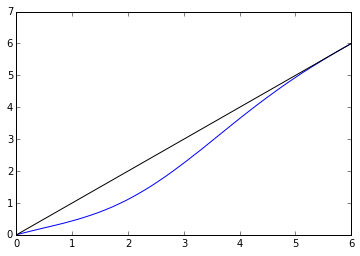

In [438]:
sample1 = sampleGP(regPrior,t[:,None],monotone=True)

plt.plot(t,sample1);
plt.plot(t,t,'k')

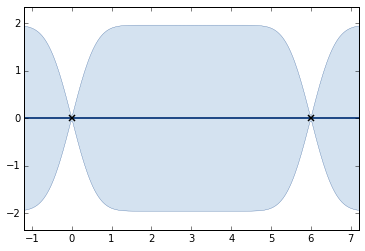

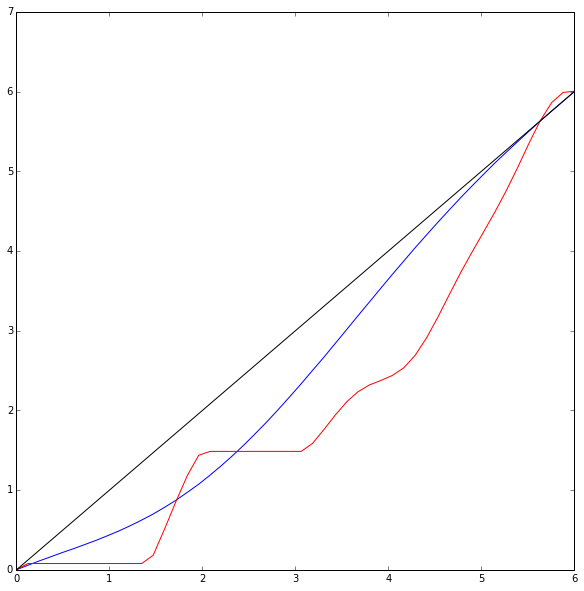

In [444]:
sample2 = proposalSample(t[:,None],sample1,.1)

plt.figure(figsize=(10,10))
plt.plot(t,sample1);
plt.plot(t,sample2,'r');
plt.plot(t,t,'k')

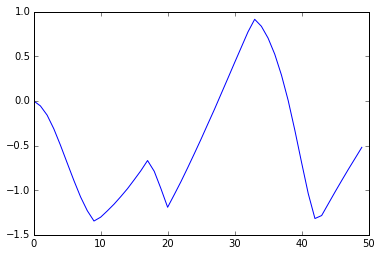

In [443]:
plt.plot(sample1-sample2)

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f67777bf410>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f67777a3b10>],
  [<matplotlib.lines.Line2D at 0x7f67777b2910>]]}

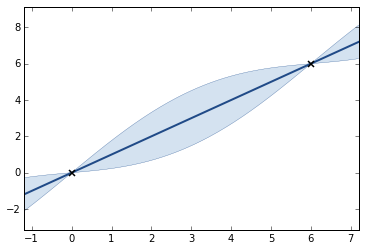

In [392]:
regPrior.plot()

In [212]:
def gpLogLikelihood(gp,x,y):
    mu,cov = gp.predict(x,full_cov=True)
    return scipy.stats.multivariate_normal.logpdf(y,mu[:,0],cov)

In [187]:
def jointLogLikelihood(h,y):
    n = h.shape[0]
    k = h.shape[1]
    
    assert n == y.shape[0], 'unmatched samples'
    assert k == y.shape[1], 'unmatched samples'
    
    x = []
    ynew = []
    for i in range(k):
        x.extend(h[:,i].tolist())
        ynew.extend(y[:,i].tolist())
        
    x = np.array(x)[:,None]
    ynew = np.array(ynew)[:,None]
    
    gp = GPy.models.GPRegression(x,ynew)
    gp.optimize()
    return gp.log_likelihood()

In [376]:
def proportionalLogPosterior(h,y,regPrior,verbose=False):
    k = h.shape[1]
    n = h.shape[0]
    
    assert n==y.shape[0],'unmatched sample size'
    assert k == y.shape[1], 'unmatched samples'
    
    priorLikelihood = np.sum([gpLogLikelihood(regPrior,t[:,None],hs) for hs in h.T.tolist()])
    logLiklihood = jointLogLikelihood(h,y)
    
    if verbose:
        print "total=%.2lf, prior-ll=%.2lf, ll=%.2lf" %(priorLikelihood+logLiklihood,priorLikelihood,logLiklihood)
    
    return logLiklihood + priorLikelihood  

In [234]:
jointLogLikelihood(hsamplesInvert.T,xRegSample.T)

-31.881008500122775

In [227]:
jointLogLikelihood(np.array([t]*k).T,xRegSample.T)

-238.7478692778738

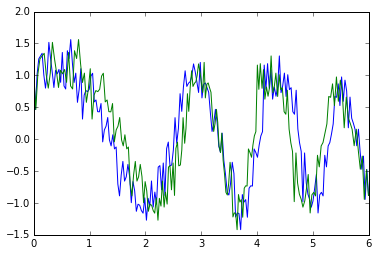

In [191]:
plt.plot(t,xRegSample[0,:])
plt.plot(hsamples[0,:],xRegSample[0,:])

In [240]:
proportionalLogPosterior(hsamplesInvert.T,xRegSample.T,regPrior,verbose=True)

prior-ll=147.48, ll=-31.88


115.59581414642444

In [241]:
proportionalLogPosterior(np.array([t]*k).T,xRegSample.T,regPrior,verbose=True)

prior-ll=1368.43, ll=-238.75


1129.6821310851053

(0, 6)

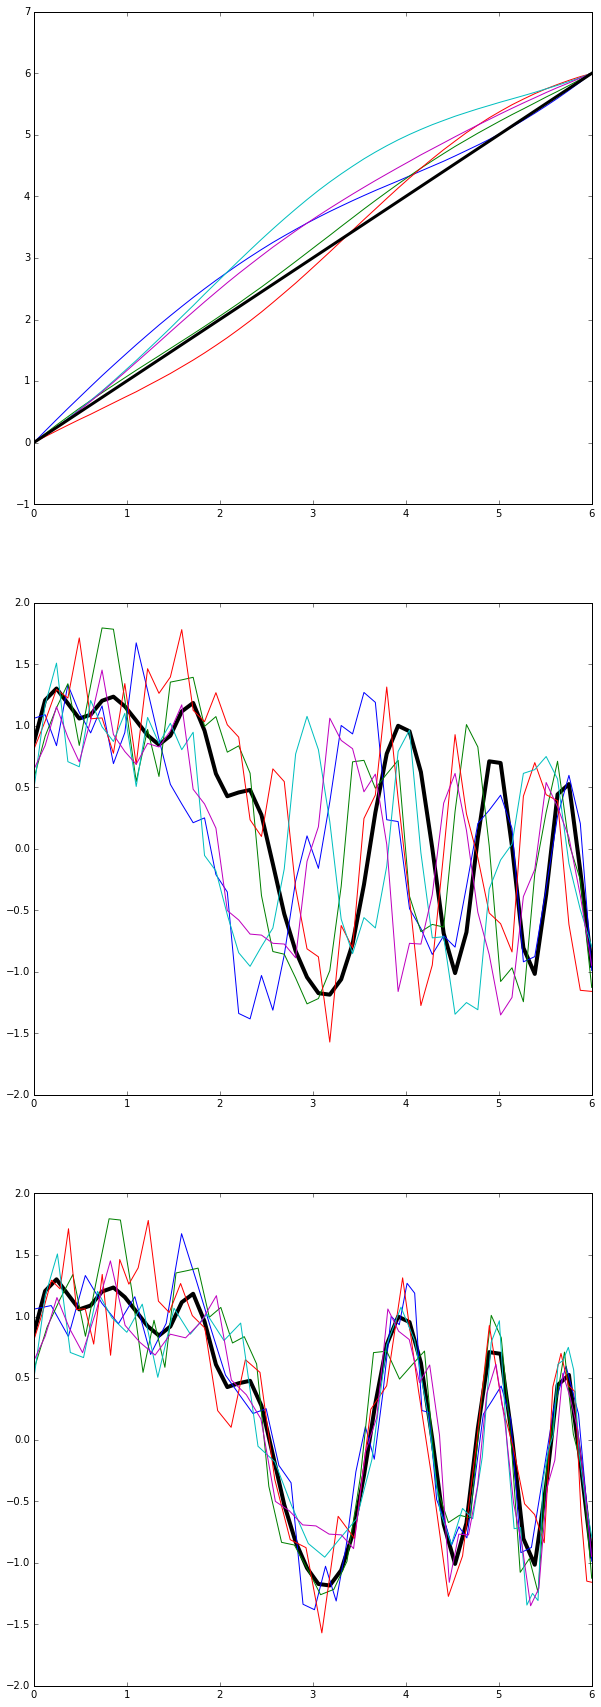

In [497]:
regPrior = registrationPrior(0,6,.4)
hsamples = sampleGP(regPrior,t[:,None],k,monotone=True)

yGP = GPy.models.GPRegression(t[:,None],x[:,None]+ scipy.stats.norm.rvs(scale=.2,size=n)[:,None])
yGP.optimize()

xsamples = np.array([sampleGP(yGP,h[:,None]) for h in hsamples])


plt.figure(figsize=(10,30))
plt.subplot(312)
plt.plot(t,yGP.predict(t[:,None])[0],'k',linewidth=4)
plt.plot(t,xsamples.T)

plt.subplot(311)
plt.plot(t,hsamples.T)
plt.plot(t,t,'k',linewidth=3)

plt.subplot(313)
plt.plot(t,yGP.predict(t[:,None])[0],'k',linewidth=4)
plt.plot(hsamples.T,xsamples.T)
plt.xlim(0,6)

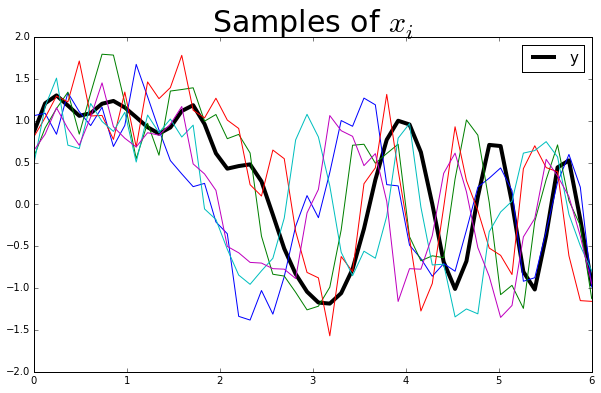

In [501]:
plt.figure(figsize=(10,6))
plt.plot(t,yGP.predict(t[:,None])[0],'k',linewidth=4,label="y")
plt.plot(t,xsamples.T)
plt.title("Samples of $x_i$",fontsize=30)
plt.legend(loc="best",fontsize=15)
plt.savefig("figures/bayesianModel_functionSamples.png",bbox_inches="tight",dpi=300)

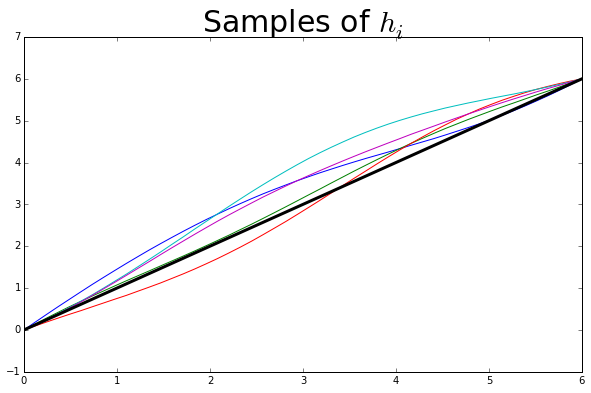

In [504]:
plt.figure(figsize=(10,6))
plt.plot(t,hsamples.T)
plt.plot(t,t,'k',linewidth=3)
plt.title("Samples of $h_i$",fontsize=30)
# plt.legend(loc="best",fontsize=15)
plt.savefig("figures/bayesianModel_registrationSamples.png",bbox_inches="tight",dpi=300)

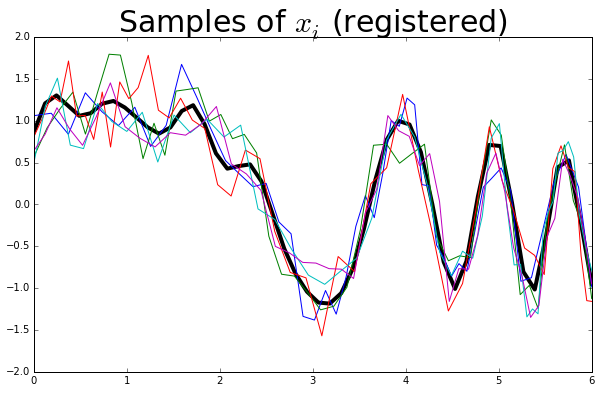

In [506]:
plt.figure(figsize=(10,6))
plt.plot(t,yGP.predict(t[:,None])[0],'k',linewidth=4)
plt.plot(hsamples.T,xsamples.T)
plt.xlim(0,6)
plt.title("Samples of $x_i$ (registered)",fontsize=30)
plt.savefig("figures/bayesianModel_functionSamples_registeredActual.png",bbox_inches="tight",dpi=300)

In [321]:
proportionalLogPosterior(hsamples.T,xsamples.T,regPrior,verbose=True)

total=1185.16,prior-ll=1230.69, ll=-45.53


1185.1626817021811

In [322]:
proportionalLogPosterior(np.array([t]*k).T,xsamples.T,regPrior,verbose=True)

total=1083.57,prior-ll=1343.13, ll=-259.56


1083.5686329415903

In [323]:
sample1 = np.array([proposalSample(t[:,None],t,.5) for i in range(k)]).T
proportionalLogPosterior(sample1,xsamples.T,regPrior,verbose=True)

total=933.51,prior-ll=1213.21, ll=-279.70


933.51496756062943

In [526]:
# hcurrent = np.array([t]*k).T
hcurrent = np.array([sampleGP(regPrior,t[:,None],monotone=True) for i in range(k)]).T
burnin = 1000
numiter = 2000
recordSkip = 1
        
hHistory = [hcurrent]
probHistory = [proportionalLogPosterior(hcurrent,xsamples.T,regPrior,verbose=True)]

for z in range(numiter*recordSkip):

#     sample = np.array([proposalSample(t[:,None],hcurrent[:,i],3) for i in range(k)]).T
    sample = np.array([sampleGP(regPrior,t[:,None],monotone=True) for i in range(k)]).T
    
    oldLikelihood = probHistory[-1]
    newLikelihood = proportionalLogPosterior(sample,xsamples.T,regPrior,verbose=i%recordSkip==0)
    
    threshold = np.log(scipy.stats.uniform.rvs(0,1))
    
#     print "diff: %.2lf, threshold: %.2lf" %(newLikelihood-oldLikelihood,threshold)
    
    if newLikelihood > oldLikelihood or (newLikelihood-oldLikelihood) > threshold:
        hcurrent = sample
        if z % recordSkip == 0:
            hHistory.append(sample)
            probHistory.append(newLikelihood)
    else:
        if z % recordSkip == 0:
            hHistory.append(hHistory[-1])
            probHistory.append(oldLikelihood)

total=966.93, prior-ll=1232.55, ll=-265.62
total=934.85, prior-ll=1205.74, ll=-270.89
total=957.14, prior-ll=1204.29, ll=-247.15
total=945.46, prior-ll=1223.48, ll=-278.03
total=993.64, prior-ll=1239.14, ll=-245.50
total=954.81, prior-ll=1220.22, ll=-265.41
total=944.30, prior-ll=1212.98, ll=-268.69
total=977.06, prior-ll=1217.74, ll=-240.68
total=948.49, prior-ll=1218.24, ll=-269.75
total=941.89, prior-ll=1200.63, ll=-258.74
total=959.28, prior-ll=1206.14, ll=-246.86
total=967.91, prior-ll=1215.01, ll=-247.09
total=966.54, prior-ll=1224.42, ll=-257.87
total=958.01, prior-ll=1220.37, ll=-262.36
total=965.14, prior-ll=1221.22, ll=-256.08
total=965.60, prior-ll=1226.62, ll=-261.01
total=986.73, prior-ll=1248.17, ll=-261.44
total=939.30, prior-ll=1211.13, ll=-271.83
total=942.63, prior-ll=1205.11, ll=-262.48
total=954.58, prior-ll=1219.01, ll=-264.43
total=988.03, prior-ll=1217.47, ll=-229.44
total=975.75, prior-ll=1221.77, ll=-246.02
total=916.95, prior-ll=1190.02, ll=-273.06
total=974.5

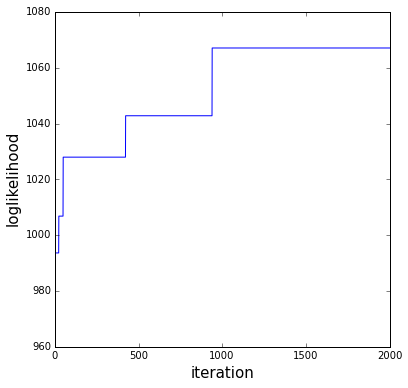

In [527]:
plt.figure(figsize=(6,6))
plt.plot(probHistory)
plt.ylabel("loglikelihood",fontsize=15)
plt.xlabel("iteration",fontsize=15)

plt.savefig("figures/bayesianModel_mcmcError.png",dpi=300,bbox_inches="tight")

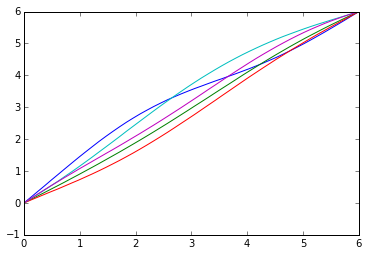

In [528]:
plt.plot(t,hHistory[-1])

(0, 6)

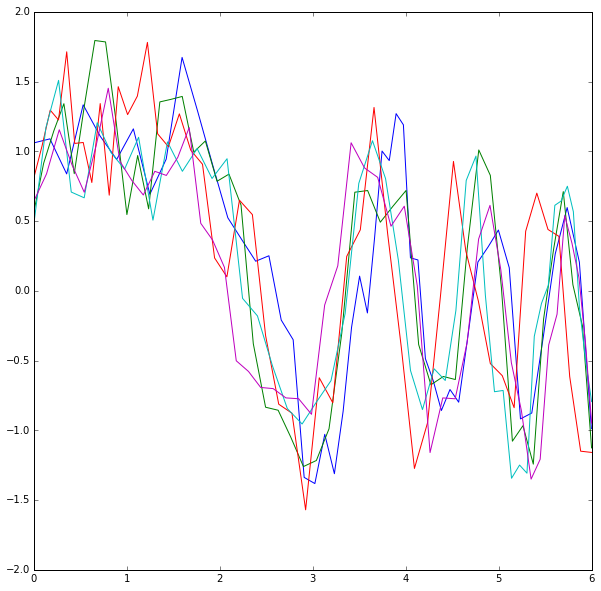

In [529]:
plt.figure(figsize=(10,10))
# plt.plot(t,yGP.predict(t[:,None])[0],'k',linewidth=4)
plt.plot(hHistory[-1],xsamples.T)
plt.xlim(0,6)

In [514]:
len(hHistory)

2001

(0, 6)

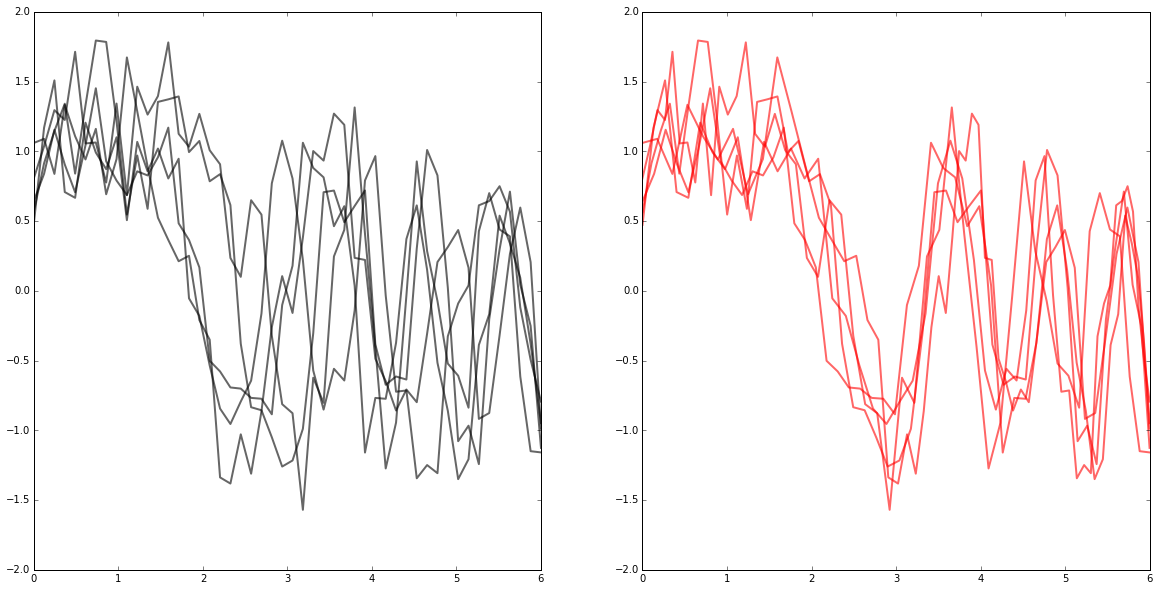

In [530]:
plt.figure(figsize=(20,10))
# plt.plot(t,yGP.predict(t[:,None])[0],'k',linewidth=4)
plt.subplot(121)
plt.plot(t[:,None],xsamples.T,'k',alpha=.6,linewidth=2)

plt.subplot(122)
plt.plot(hHistory[-1],xsamples.T,'r',alpha=.6,linewidth=2)
plt.xlim(0,6)

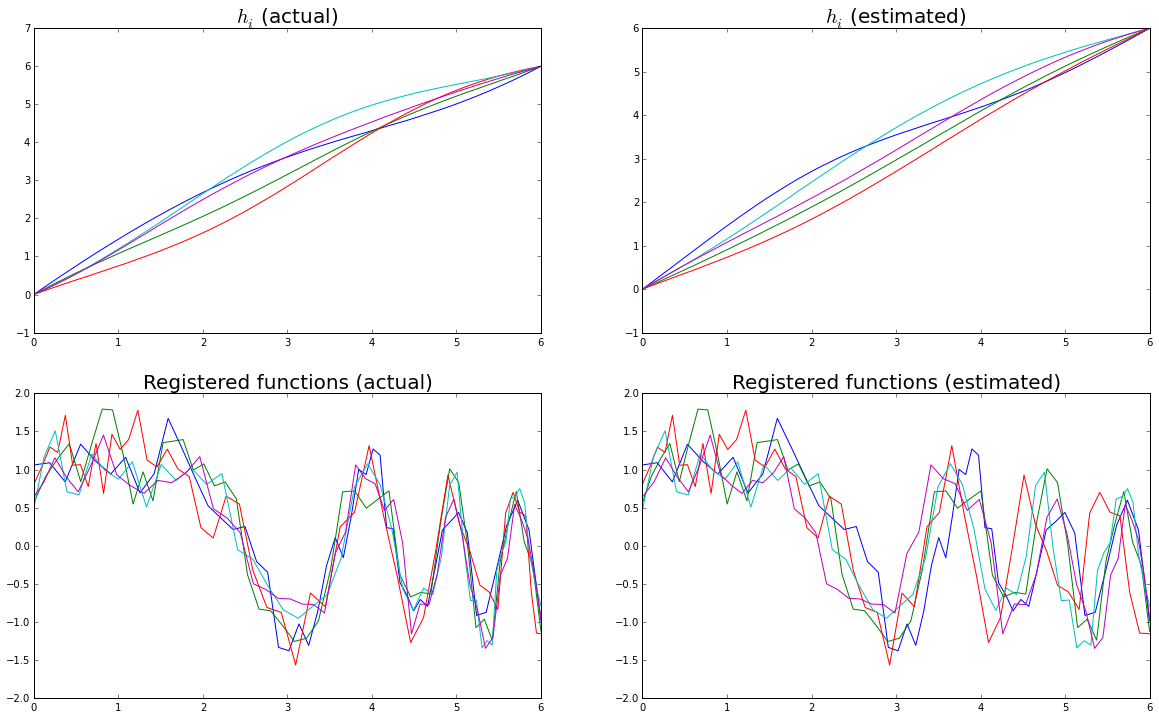

In [531]:
plt.figure(figsize=(20,12))

plt.subplot(221)
plt.plot(t,hsamples.T)
plt.xlim(0,6)
plt.title("$h_i$ (actual)",fontsize=20)

plt.subplot(222)
plt.plot(t,hHistory[-1])
plt.xlim(0,6)
plt.title("$h_i$ (estimated)",fontsize=20)

plt.subplot(223)
plt.plot(hsamples.T,xsamples.T)
plt.xlim(0,6)
plt.title("Registered functions (actual)",fontsize=20)

plt.subplot(224)
plt.plot(hHistory[-1],xsamples.T)
plt.xlim(0,6)
plt.title("Registered functions (estimated)",fontsize=20)

plt.savefig("figures/bayesianModel_registeredSamples_beforeAfter.png",dpi=300,bbox_inches="tight")

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f6772f567d0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f6772f726d0>],
  [<matplotlib.lines.Line2D at 0x7f6772f56150>]]}

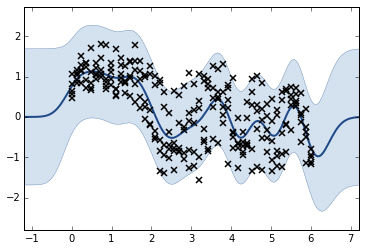

In [532]:
xtemp = np.ravel([[t]*k])[:,None]
ytemp = np.ravel(xsamples)[:,None]

yGP_init = GPy.models.GPRegression(xtemp,ytemp)
yGP_init.optimize()
yGP_init.plot()

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f6772a2e690>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f677449ad90>],
  [<matplotlib.lines.Line2D at 0x7f67744b5b90>]]}

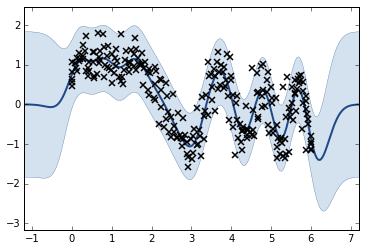

In [533]:
xtemp = np.ravel(hHistory[-1].T)[:,None]
ytemp = np.ravel(xsamples)[:,None]

yGP_final = GPy.models.GPRegression(xtemp,ytemp)
yGP_final.optimize()
yGP_final.plot()

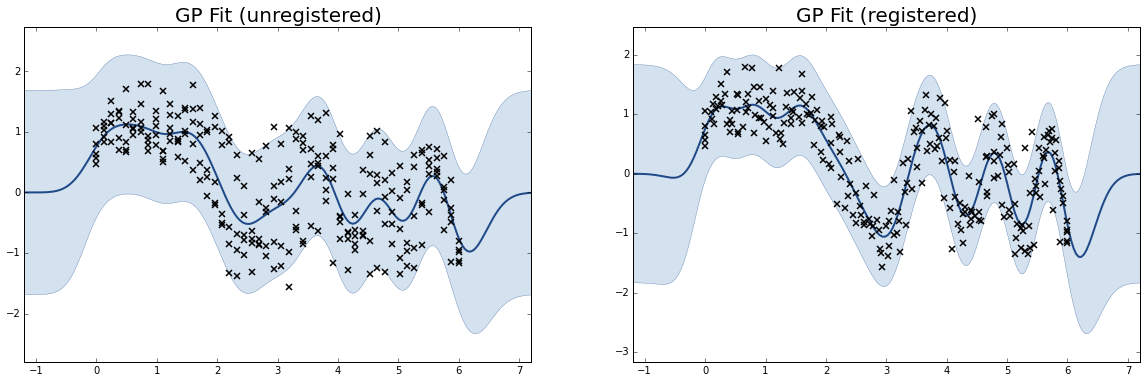

In [534]:
plt.figure(figsize=(20,6))
ax = plt.subplot(121)
yGP_init.plot(ax=ax)
plt.title("GP Fit (unregistered)",fontsize=20)

ax = plt.subplot(122)
yGP_final.plot(ax=ax)
plt.title("GP Fit (registered)",fontsize=20)

plt.savefig("figures/bayesianModel_gpEstimates_beforeAfter.png",dpi=300,bbox_inches="tight")

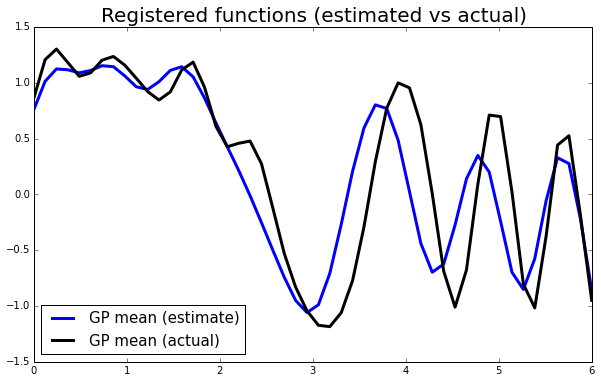

In [535]:
plt.figure(figsize=(10,6))
# plt.plot(hHistory[-1],xsamples.T)
plt.plot(t,yGP_final.predict(t[:,None])[0][:,0],linewidth=3,label='GP mean (estimate)')
plt.plot(t,yGP.predict(t[:,None])[0][:,0],'k',linewidth=3,label='GP mean (actual)')
plt.xlim(0,6)
plt.title("Registered functions (estimated vs actual)",fontsize=20)
plt.legend(loc="best",fontsize=15)

plt.savefig("figures/bayesianModel_gpEstimates_vsActual.png",dpi=300,bbox_inches="tight")

In [332]:
# hcurrent = np.array([t]*k).T
hcurrent = np.array([sampleGP(regPrior,t[:,None],monotone=True) for i in range(k)]).T
burnin = 1000
numiter = 500
recordSkip = 10

hHistory = [hcurrent]
probHistory = [proportionalLogPosterior(hcurrent,xsamples.T,regPrior,verbose=True)]

for b in range(burnin):
    hcurrent = hHistory[-1]
    sample = np.array([proposalSample(t[:,None],hcurrent[:,i],.99) for i in range(k)]).T
    
    oldLikelihood = probHistory[-1]
    newLikelihood = proportionalLogPosterior(sample,xsamples.T,regPrior,verbose=False)
    
    threshold = np.log(scipy.stats.uniform.rvs(0,1))
    
    if newLikelihood > oldLikelihood or (newLikelihood-oldLikelihood) > threshold:
        hHistory.append(sample)
        probHistory.append(newLikelihood)
    else:
        hHistory.append(hHistory[-1])
        probHistory.append(oldLikelihood)
        
hHistory = [hcurrent]
probHistory = [proportionalLogPosterior(hcurrent,xsamples.T,regPrior,verbose=True)]

for z in range(numiter*recordSkip):
    
    if z % 100 == 0:
        print z

    sample = np.array([proposalSample(t[:,None],hcurrent[:,i],.99) for i in range(k)]).T
    
    oldLikelihood = probHistory[-1]
    newLikelihood = proportionalLogPosterior(sample,xsamples.T,regPrior,verbose=i%recordSkip==0)
    
    threshold = np.log(scipy.stats.uniform.rvs(0,1))
    
#     print "diff: %.2lf, threshold: %.2lf" %(newLikelihood-oldLikelihood,threshold)
    
    if newLikelihood > oldLikelihood or (newLikelihood-oldLikelihood) > threshold:
        hcurrent = sample
        if z % recordSkip == 0:
            hHistory.append(sample)
            probHistory.append(newLikelihood)
    else:
        if z % recordSkip == 0:
            hHistory.append(hHistory[-1])
            probHistory.append(oldLikelihood)

total=949.41,prior-ll=1216.03, ll=-266.62
total=949.41,prior-ll=1216.03, ll=-266.62
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [331]:
numiter*recordSkip

5000

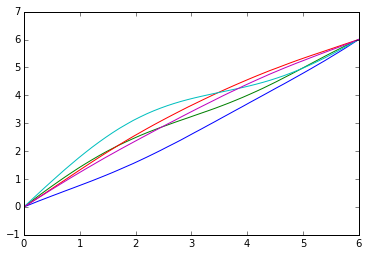

In [325]:
plt.plot(t,hcurrent)

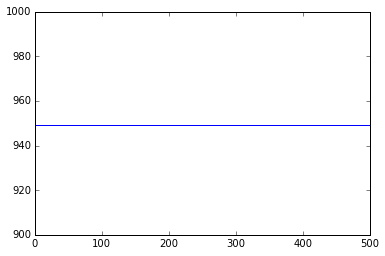

In [333]:
plt.plot(probHistory)

In [318]:
scipy.stats.uniform.rvs()

0.4600203134520192